In [27]:
############ Calculate Horizon Distances #################
import pycbc.psd
import numpy

from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigma
from pycbc.cosmology import redshift

import tqdm

dur = 32
sr = 4096
flow = 5.05
df = 1.0 / dur
tlen = sr * dur
flen = tlen // 2 + 1

det_masses = numpy.logspace(-1, 3.6, 300)

############# CE designs noise ###################################
ce_40k_det = pycbc.psd.from_txt("ce_strain/cosmic_explorer_40km_lf_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)    

ce_40k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

ce_20k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_20km_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)


aplus = pycbc.psd.from_txt("ligo_strain/AplusDesign.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

asharp = pycbc.psd.from_txt("ligo_strain/Asharp_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)
   
ce_psds = {'CE:Detect':ce_40k_det,
           'CE:Broad': ce_40k_base, 
           'CE:20km': ce_20k_base,
           'A+':aplus,
           'A#':asharp,
          }
############ read in noise budget ###################
import numpy
from pycbc.types import FrequencySeries

noise = numpy.genfromtxt('ce_strain/CEnoisebudget.csv', delimiter=',', names=True)

names = list(noise.dtype.names)
names.remove('Frequency')

freq = noise['Frequency']

f = numpy.arange(0, 6000, df)

noise_psds = {}

for t in names:
    noise_psds[t] = FrequencySeries(numpy.interp(f, freq, noise[t]), delta_f=df)
    
################ get horizons distance ##################
signal_amp_limit = {k: [] for k in noise_psds}
signal_amp = {k: [] for k in ce_psds}
for m in tqdm.tqdm(det_masses):
    hp, hc = get_fd_waveform(approximant="IMRPhenomXPHM",
                             mass1=m,
                             mass2=m,
                             f_lower=flow,
                             delta_f=df,
                             f_final=2048,
                             )
    for k in noise_psds:
        hp.resize(len(noise_psds[k]))
        amp = sigma(hp, psd=noise_psds[k]**2.0, low_frequency_cutoff=flow)
        signal_amp_limit[k].append(amp)
        
    for k in ce_psds:
        p = ce_psds[k]
        hp.resize(len(p))
        amp = sigma(hp, psd=p, low_frequency_cutoff=flow)
        signal_amp[k].append(amp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:21<00:00, 14.03it/s]


In [28]:
########### Generate Populations ################
from pycbc.distributions import draw_samples_from_config
import os.path
import h5py

if os.path.exists('./_population_saved.hdf'):
    f = h5py.File('./_population_saved.hdf', 'r')
    bns = f['bns'][:]
    bbh = f['bbh'][:]
else:
    bns = draw_samples_from_config('populations/bns.ini', int(1e6))
    bbh = draw_samples_from_config('populations/bbh.ini', int(1e5))
    f = h5py.File('./_population_saved.hdf', 'w')
    f['bns'] = bns
    f['bbh'] = bbh

In [29]:
# Generate fiducial pop III population
import numpy.random
psize = 200
popthree = {}
popthree['redshift'] = numpy.random.normal(17, 5, size=psize)
popthree['mass'] = numpy.random.normal(60, 20, size=psize)
# quick and dirty eyeball from here temporarily 2303.15515.pdf

In [30]:
# Generate fiducial  QCD Phase transition PBHs #placeholder
import numpy.random
psize = 5000
pbh = {}
pbh['redshift'] = numpy.log(numpy.random.uniform(0, numpy.e**0.25, size=psize))*1200
pbh['mass'] = numpy.random.normal(0.7*2.0, 1.0, size=psize)

/home/ahnitz/projects/env/lib64/python3.11/site-packages/astropy/cosmology/flrw/base.py:1130: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(self._inv_efunc_scalar, z1, z2, args=self._inv_efunc_scalar_args)[0]


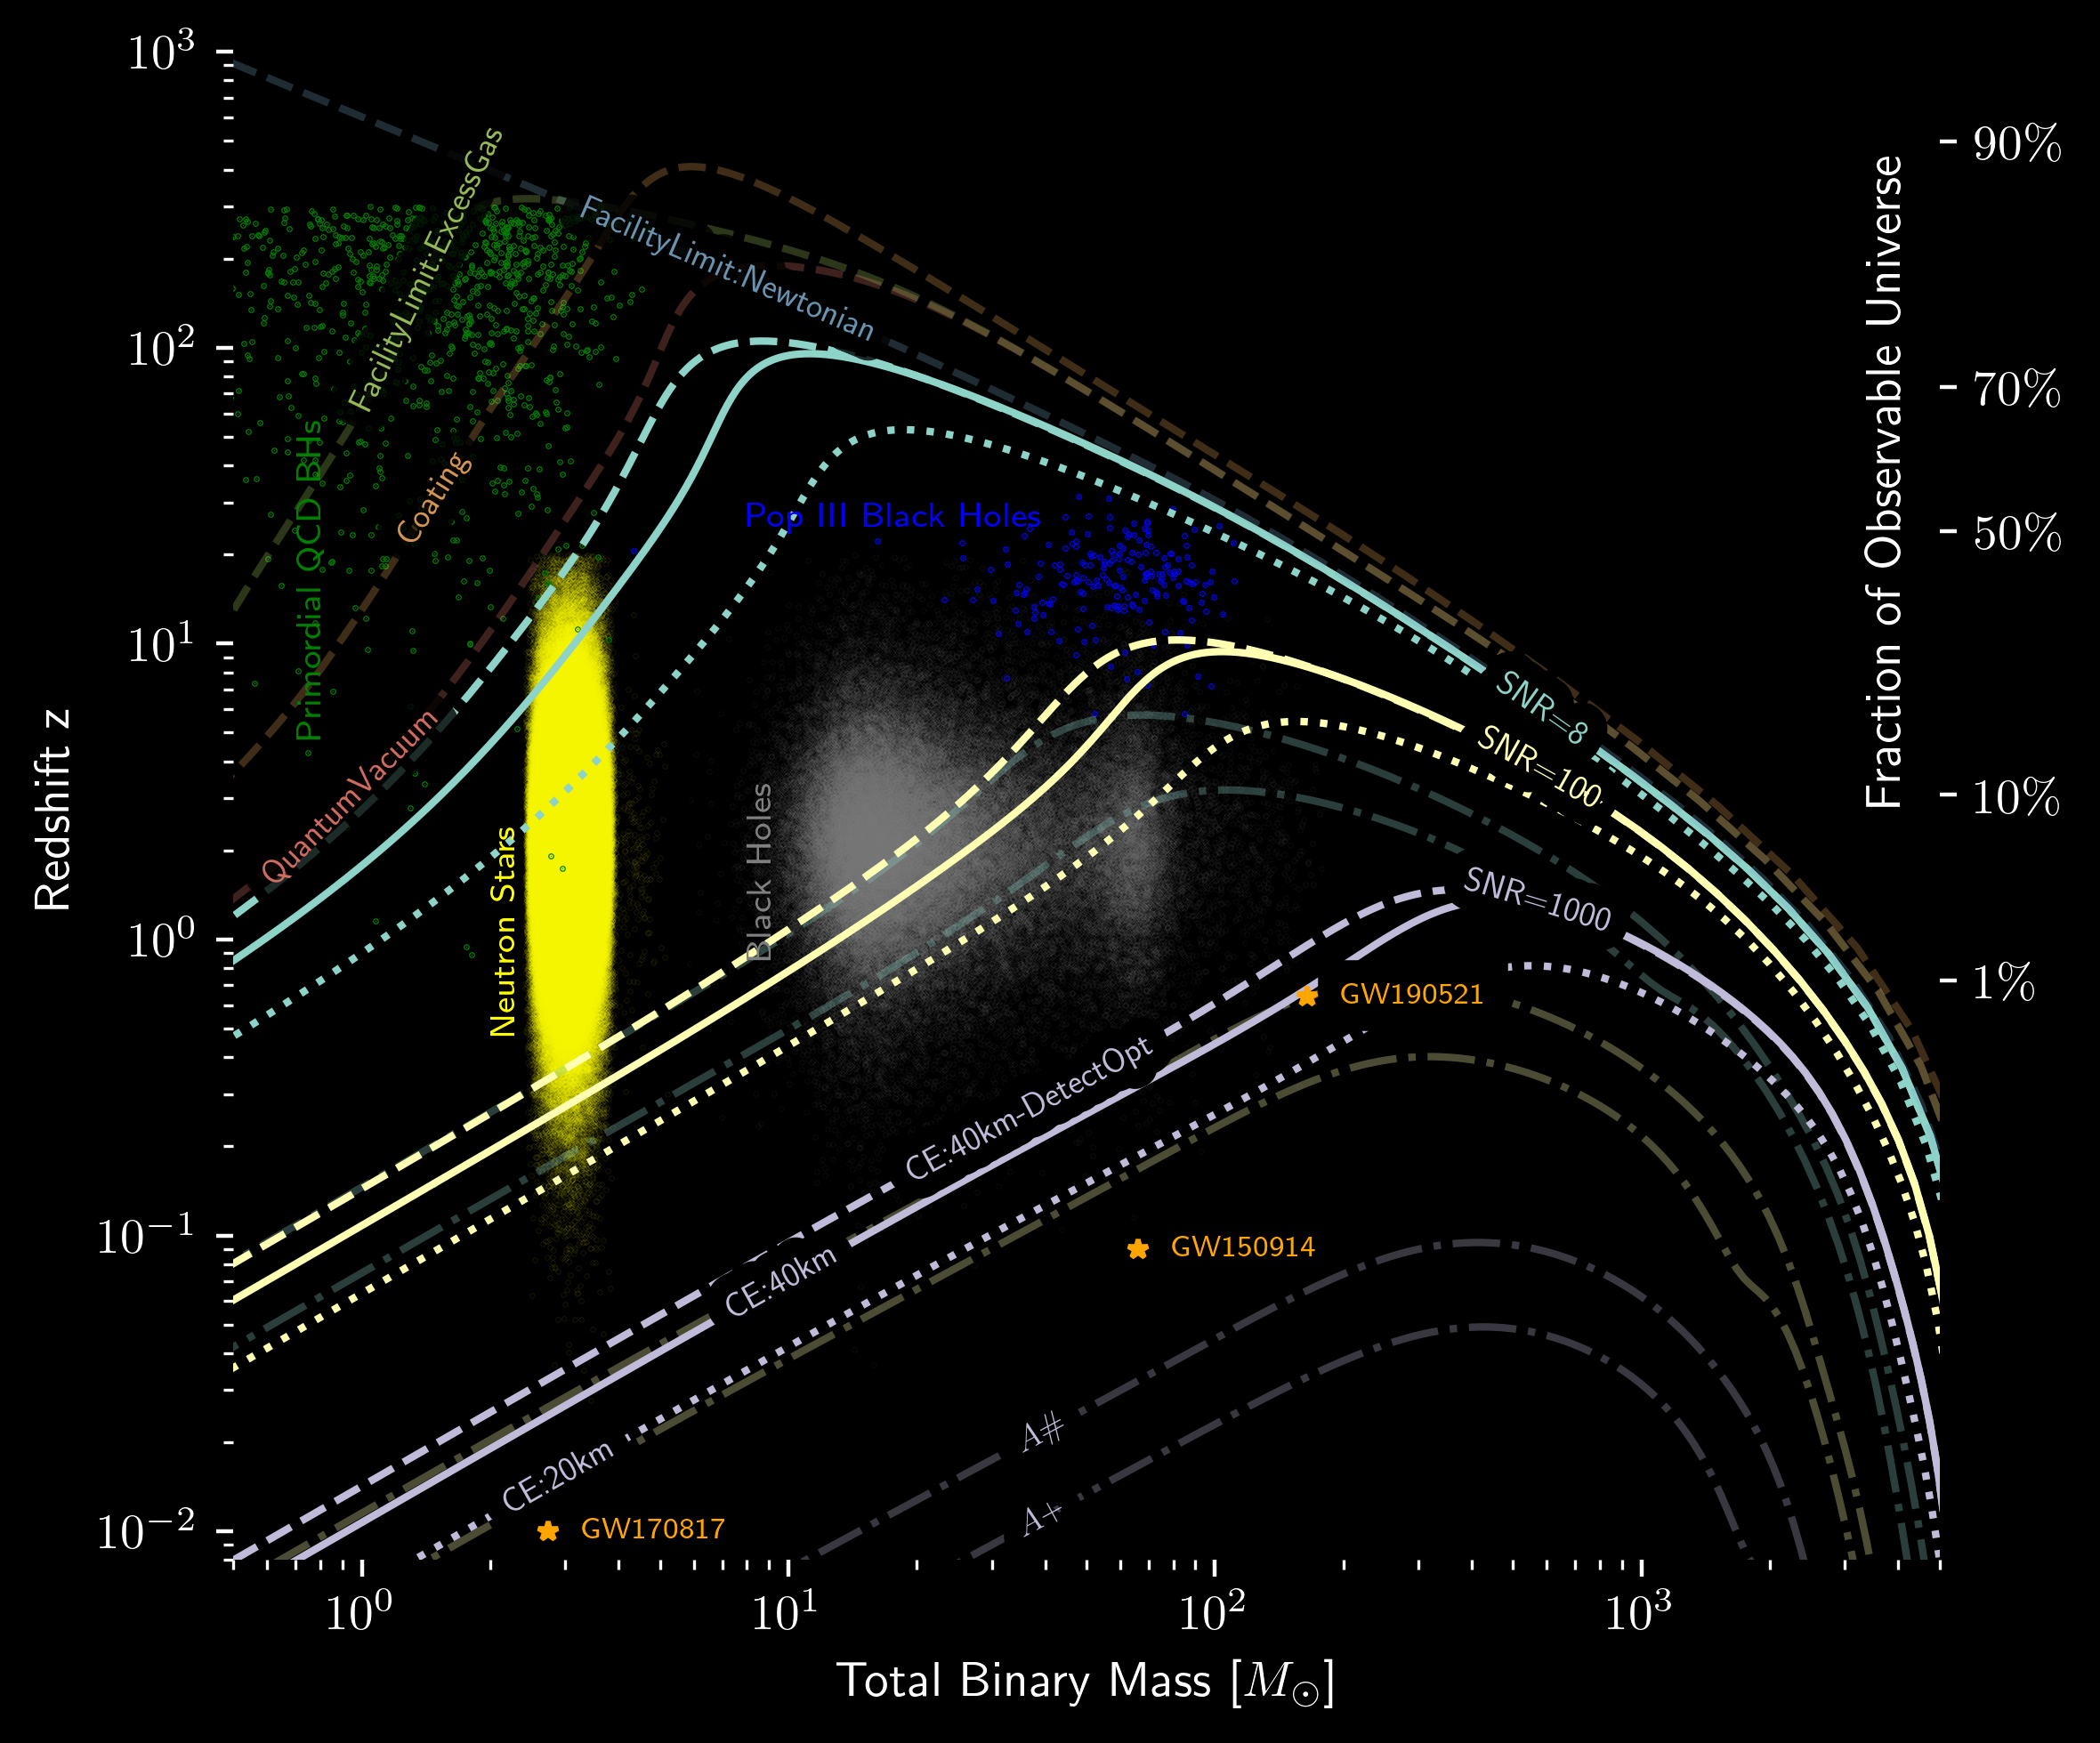

In [38]:
# Make plot ##########
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines, labelLine

plt.figure(figsize=[6, 5], dpi=400)
plt.style.use('dark_background')
plt.rc('text', usetex=True)

plt.ylim(0.008, 1000)
plt.xlim(0.5, 5000)
#plt.xlim(1, 300)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Binary Mass [$M_\odot$]')
plt.ylabel('Redshift z')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

####### Secondary y axis #################################
import astropy.cosmology

cosmo = astropy.cosmology.Planck15
maxvol = cosmo.comoving_volume(1e6)
zref = numpy.arange(0, 10000, 1)
frac = cosmo.comoving_volume(zref) / maxvol

def forward(z):
    return numpy.interp(z, zref, frac)

def inverse(z):
    return numpy.interp(z, frac, zref)

ax2 = plt.gca().secondary_yaxis('right', functions=(forward, inverse))
ax2.set_ylabel('Fraction of Observable Universe', horizontalalignment='left', labelpad=-40)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().get_major_formatter().labelOnlyBase = False
ax2.set_yticks([.01, .1, .5, .7, .90])
ax2.set_yticklabels([ "$1\\%$", "$10\\%$", "$50\\%$", "$70\\%$", "$90\\%$"])
ax2.minorticks_off()

# add horizon distance lines ####################################

    
for snr, alpha in zip([8, 100, 1000], [1, 0.5, 0.5]):
    # 40k
    z = redshift(numpy.array(signal_amp['CE:Broad']) / snr)
    src_mass = det_masses * 2.0 / (1 + z) 
    p1 = plt.plot(src_mass, z, alpha=1.0, linestyle='-')
    
    # 40k - lf
    z = redshift(numpy.array(signal_amp["CE:Detect"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p2 = plt.plot(src_mass, z, 
            color=p1[-1].get_color(), alpha=1.0, linestyle='dashed')

    # 20k
    z = redshift(numpy.array(signal_amp["CE:20km"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p3 = plt.plot(src_mass, z, 
            color=p1[-1].get_color(), alpha=1.0, linestyle='dotted')
    
    # A+
    z = redshift(numpy.array(signal_amp["A+"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p4 = plt.plot(src_mass, z, 
            color=p1[-1].get_color(), linestyle='dashdot', alpha=0.3)
    
    # A#
    z = redshift(numpy.array(signal_amp["A#"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p5 = plt.plot(src_mass, z, 
            color=p1[-1].get_color(), linestyle='dashdot', alpha=0.3)
    
    
    if snr == 1000:
        labelLine(p1[0], 10, label='CE:40km', align=True, fontsize=7)
        labelLine(p2[0], 40, label='CE:40km-DetectOpt', align=True, fontsize=7)
        labelLine(p3[0], 3, label='CE:20km', align=True, fontsize=7)
        labelLine(p4[0], 40, label='$A+$', align=True, fontsize=7)
        labelLine(p5[0], 40, label='$A\\#$', align=True, fontsize=7)
        

    labelLine(p2[0], 600, label=f"SNR={snr}", fontsize=7, zorder=1000, alpha=1.0)
    
#labelLines(plt.gca().get_lines(), align=True, fontsize=10)

# add facility horizon limit ###################################

xvals = {'QuantumVacuum':1, 
         'ExcessGas':1.5,
         'Coating':1.5,
         'Substrate':40,
         'SuspensionThermal':1.3,
         'Newtonian':8,
        }

for k in signal_amp_limit:
    if k in ['Total', 'Substrate',
             'Seismic', 'SuspensionThermal',
             ]:
        continue
        
    if k == 'ExcessGas':
        label = 'FacilityLimit:ExcessGas'
    elif k == 'Newtonian':
        label = 'FacilityLimit:Newtonian'
    else:
        label = k
        
    ldist_horizon = numpy.array(signal_amp_limit[k]) / 8.0
    
    if k in xvals:
        xval = xvals[k]
    else:
        xval = 5

    z = redshift(ldist_horizon)
    src_mass = det_masses / (1 + z)
    plt.plot(src_mass * 2.0, z, label=label, linestyle='--', alpha=0.25)
    labelLine(plt.gca().get_lines()[-1], xval, align=True, fontsize=7, alpha=0.8)

# add interesting single events#################################
from pycbc.catalog import Merger

m = Merger("GW170817")
x, y = m.mass1 + m.mass2, m.redshift
plt.plot(x, y, '*', color='orange', markersize=4, zorder=10)
plt.text(x*1.2, y/1.05, 'GW170817', fontsize=6, color='orange', zorder=9)

m = Merger("GW150914")
x, y = m.mass1 + m.mass2, m.redshift
plt.plot(x, y, '*', color='orange', markersize=4, zorder=10)
plt.text(x*1.2, y/1.05, 'GW150914', fontsize=6, color='orange', zorder=9)

m = Merger("GW190521", source='gwtc-2')
x, y = m.mass1 + m.mass2, m.redshift
plt.plot(x, y, '*', color='orange', markersize=4, zorder=10)
t = plt.text(x*1.2, y/1.05, 'GW190521', fontsize=6, color='orange', backgroundcolor='black', zorder=9)

##################################################
# Add populations of events

plt.scatter(bns['srcmass1'] + bns['srcmass2'], bns['redshift'], s=0.001, rasterized=True, alpha=0.5, color='yellow')
plt.text(2.0, .5, 'Neutron Stars', rotation=90, fontsize=7, color='yellow')

plt.scatter(bbh['srcmass1'] + bbh['srcmass2'], bbh['redshift'], s=0.001, rasterized=True, alpha=0.5, color='grey')
plt.text(8.0, .9, 'Black Holes', rotation=90, fontsize=7, color='grey')


plt.scatter(popthree['mass'], popthree['redshift'], color='blue', s=0.05, alpha=1.0)
plt.text(8.0, 25, 'Pop III Black Holes', fontsize=7, color='blue')

plt.scatter(pbh['mass'], pbh['redshift'], color='green', s=0.05, alpha=1.0)
plt.text(0.7, 5, 'Primordial QCD BHs', fontsize=7, rotation=90, color='green')
##################################################
plt.tight_layout()
# Add hypothetical populations